# BursterCa 

A Ca-based burster.

In [1]:
# Set the path
import sys
sys.path.append("../../")

from act.cell_model import ACTCellModel
from act.simulator import ACTSimulator
from act.types import SimulationParameters, ConstantCurrentInjection, FilterParameters, ConductanceOptions, OptimizationParameters
import act.data_processing as dp
from act.module import ACTModule

import numpy as np
import matplotlib.pyplot as plt

from act.passive import ACTPassiveModule
from act.segregation import ACTSegregator

from sklearn.metrics import mean_absolute_error
from act.metrics import pp_error

## 1. Set the "target" model and simulate from it

The "target" model's output represents the target bio data provided by the user to tune for.

Parameters:
...

In [3]:
# Define the "target" cell
target_cell = ACTCellModel(
    cell_name = "BursterCa",
    path_to_hoc_file = "../../data/BursterCa/orig/target_template.hoc",
    path_to_mod_files = "../../data/BursterCa/orig/modfiles/",
    passive = ["gbar_leak", "eleak", None],
    active_channels = ["gbar_na", "gbar_kdr", "gbar_cas", "gbar_ka", "gbar_cat"],
)

In [4]:
target_g = np.array([4e-05, 0.13, 0.1, 0.01, 0.17, 0.005])

### 1.1. Target passive properties

In [5]:
# Set simulations
simulator = ACTSimulator(output_folder_name = "output")

sim_params = SimulationParameters(
    sim_name = "target",
    sim_idx = 0,
    h_celsius = 6.3,
    h_dt = 0.1,
    h_tstop = 1000,
    CI = [ConstantCurrentInjection(amp = -0.2, dur = 700, delay = 100)])

simulator.submit_job(target_cell, sim_params)
simulator.run_jobs(1)


        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


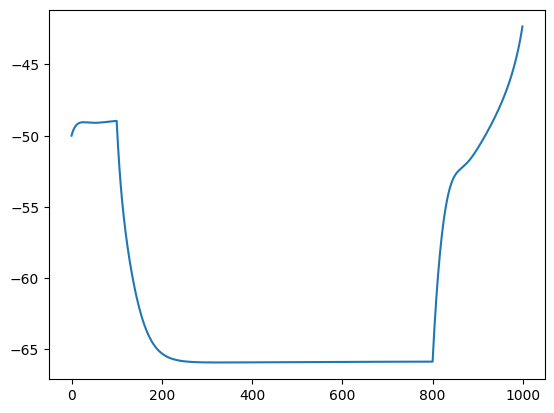

In [6]:
passive_trace = np.load("output/target/out_0.npy")[:, 0]
plt.plot(passive_trace[::10])

In [7]:
target_gpp = ACTPassiveModule.compute_gpp(passive_trace, 0.1, 100, 700, -0.2)
target_gpp

GettablePassiveProperties(R_in=84.7746764782957, tau1=33.800000000000004, tau2=205.5, sag_ratio=0.0030445454185757032, V_rest=-48.958887970375756)

### 1.2. Target FI curve

In [9]:
# Set simulations
simulator = ACTSimulator(output_folder_name = "output")

for sim_idx, amp_value in enumerate([0.1, 0.5, 1.0]):
    sim_params = SimulationParameters(
        sim_name = "target",
        sim_idx = sim_idx,
        h_celsius = 6.3,
        h_dt = 0.1,
        h_tstop = 1000,
        CI = [ConstantCurrentInjection(amp = amp_value, dur = 700, delay = 100)])

    simulator.submit_job(target_cell, sim_params)

simulator.run_jobs(3)

# Combine simulated traces into one dataset for convenience
dp.combine_data("output/target")


        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        
output/target/combined_out.npy


Text(0, 0.5, 'Voltage (mV)')

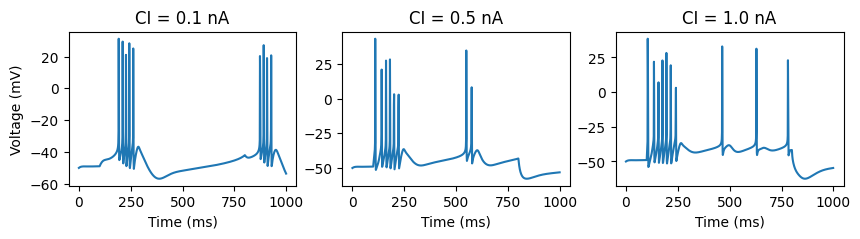

In [10]:
# Plot the traces and the FI curve
simulated_data = np.load("output/target/combined_out.npy") # 3 x 10000 x 4; (n_sim x time x [V, I, g, lto_hto])

fig, ax = plt.subplots(1, 3, figsize = (10, 2))
for axid, amp in enumerate([0.1, 0.5, 1.0]):
    ax[axid].plot(simulated_data[axid, ::10, 0])
    ax[axid].set_xlabel("Time (ms)")
    ax[axid].set_title(f"CI = {amp} nA")

ax[0].set_ylabel("Voltage (mV)")

Text(0.5, 1.0, 'FI Curve')

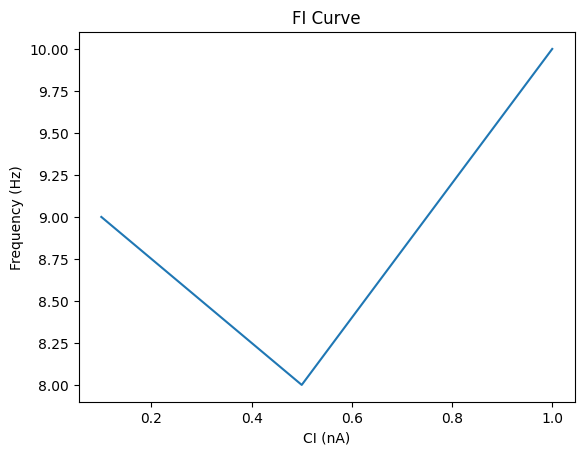

In [13]:
simulated_data = np.load("output/target/combined_out.npy")

f = []
for trace_id in range(len(simulated_data)):
    f.append(len(dp.find_events(simulated_data[trace_id, ::10, 0].flatten())))

plt.plot([0.1, 0.5, 1.0], f)
plt.xlabel("CI (nA)")
plt.ylabel("Frequency (Hz)")
plt.title("FI Curve")

## 2. Original pipeline - optimize passive and active channels together

### 2.1. Set the train cell 

We assume the train cell was acquired from an external source, e.g., AllenDB. Thus, its parameters do not necesserily match those of the target cell. Here we set these parameters to the target's values +- 10% std.

In [14]:
random_state = np.random.RandomState(123)
target_values = np.array([1, 0.12, 0.036, 0.0003, -54.3]) # Cm, gnabar, gkbar, gl, el
target_values = target_values + random_state.normal(0, np.abs(target_values * 0.1))
target_values

array([ 8.91436940e-01,  1.31968145e-01,  3.70187226e-02,  2.54811159e-04,
       -5.74417994e+01])

Train cell (updated in template.hoc):

- Cm = 0.89
- gnabar = 0.132 (S/cm2)
- gkbar = 0.037 (S/cm2)
- gl = 0.00025 (S/cm2)
- el = -57.4 (mV)

In [15]:
# Define the train cell
train_cell = ACTCellModel(
    cell_name = "BursterCa",
    path_to_hoc_file = "../../data/BursterCa/orig/target_template.hoc",
    path_to_mod_files = "../../data/BursterCa/orig/modfiles/",
    passive = ["gbar_leak", "eleak", None],
    active_channels = ["gbar_na", "gbar_kdr", "gbar_cas", "gbar_ka", "gbar_cat"],
)

### 2.2. Passive properties before tuning

In [16]:
# Set simulations
simulator = ACTSimulator(output_folder_name = "output")

sim_params = SimulationParameters(
    sim_name = "orig",
    sim_idx = 0,
    h_celsius = 6.3,
    h_dt = 0.1,
    h_tstop = 1000,
    CI = [ConstantCurrentInjection(amp = -0.2, dur = 700, delay = 100)])

simulator.submit_job(train_cell, sim_params)
simulator.run_jobs(1)

passive_trace = np.load("output/orig/out_0.npy")[:, 0]
ACTPassiveModule.compute_gpp(passive_trace, 0.1, 100, 700, -0.2)


        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


GettablePassiveProperties(R_in=84.7746764782957, tau1=33.800000000000004, tau2=205.5, sag_ratio=0.0030445454185757032, V_rest=-48.958887970375756)

### 2.3. FI curve before tuning

In [15]:
# Set simulations
simulator = ACTSimulator(output_folder_name = "output")

for sim_idx, amp_value in enumerate([0.1, 0.5, 1.0]):
    sim_params = SimulationParameters(
        sim_name = "orig",
        sim_idx = sim_idx,
        h_celsius = 6.3,
        h_dt = 0.1,
        h_tstop = 1000,
        CI = [ConstantCurrentInjection(amp = amp_value, dur = 700, delay = 100)])

    simulator.submit_job(train_cell, sim_params)

simulator.run_jobs(3)

# Combine simulated traces into one dataset for convenience
dp.combine_data("output/orig")


        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        
output/orig/combined_out.npy


Text(0.5, 1.0, 'FI Curve')

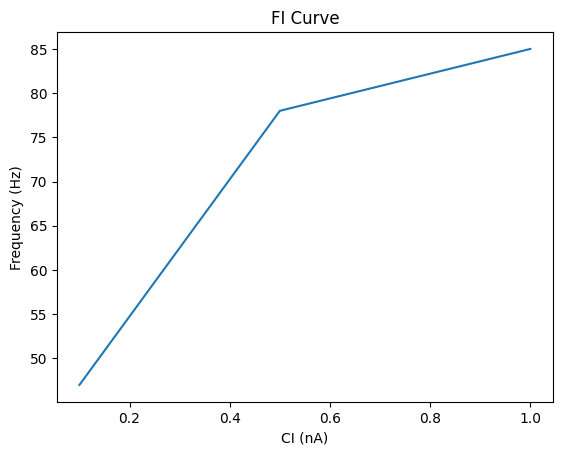

In [29]:
simulated_data = np.load("output/orig/combined_out.npy")

f = []
for trace_id in range(len(simulated_data)):
    f.append(len(dp.find_events(simulated_data[trace_id, ::10, 0].flatten())))

plt.plot([0.1, 0.5, 1.0], f)
plt.xlabel("CI (nA)")
plt.ylabel("Frequency (Hz)")
plt.title("FI Curve")

### 2.4 Optimize

In [30]:
# Parameter ranges as if provided by the user
gbar_leak = 0.00025
gbar_na = 0.132
gbar_kdr = 0.037

random_state = np.random.RandomState(123)
gbar_leak_range = (gbar_leak - random_state.uniform(0, gbar_leak / 2), gbar_leak + random_state.uniform(0, gbar_leak / 2))
gbar_na_range = (gbar_na - random_state.uniform(0, gbar_na / 2), gbar_na + random_state.uniform(0, gbar_na / 2))
gbar_kdr_range = (gbar_kdr - random_state.uniform(0, gbar_kdr / 2), gbar_kdr + random_state.uniform(0, gbar_kdr / 2))

print(f"Leak: {gbar_leak_range}")
print(f"Na: {gbar_na_range}")
print(f"Kdr: {gbar_kdr_range}")

Leak: (0.0001629413518002673, 0.00028576741686879743)
Na: (0.1170278040647626, 0.16838677475947084)
Kdr: (0.02368982405896708, 0.04482746951230253)


In [39]:
# Possibly adjsut
train_cell = ACTCellModel(
    cell_name = "Spiker",
    path_to_hoc_file = "../../data/Spiker/orig/template.hoc",
    path_to_mod_files = "../../data/Spiker/orig/modfiles/",
    passive = ["gl", "el", None],
    active_channels = ["hh_spiker.gl", "hh_spiker.gnabar", "hh_spiker.gkbar"], # "Trick" to optimize for g_leak too
)

In [42]:
sim_params = SimulationParameters(
        sim_name = "cell",
        sim_idx = 0,
        h_celsius = 6.3,
        h_dt = 0.1,
        h_tstop = 1000)

optim_params = OptimizationParameters(
    conductance_options = [
        ConductanceOptions(variable_name = "hh_spiker.gl", low = gbar_leak_range[0], high = gbar_leak_range[1], n_slices = 3),
        ConductanceOptions(variable_name = "hh_spiker.gnabar", low = gbar_na_range[0], high = gbar_na_range[1], n_slices = 3),
        ConductanceOptions(variable_name = "hh_spiker.gkbar", low = gbar_kdr_range[0], high = gbar_kdr_range[1], n_slices = 3),  
    ],
    CI_options = [
        ConstantCurrentInjection(amp = 0.1, dur = 700, delay = 100),
        ConstantCurrentInjection(amp = 0.5, dur = 700, delay = 100),
        ConstantCurrentInjection(amp = 0.7, dur = 700, delay = 100)
    ],
    filter_parameters = FilterParameters(
        saturation_threshold = -55,
        window_of_inspection = (100, 800)
    )
)

m = ACTModule(
    name = "orig",
    cell = train_cell,
    simulation_parameters = sim_params,
    optimization_parameters = optim_params,
    target_file = "/Users/vladimiromelyusik/ACT/experiments/Spiker/output/target/combined_out.npy"
)

In [43]:
m.run()

Running Module 'orig'...
----------
Simulating train traces...

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        
/Users/vladimiromelyusik/ACT/experiments/Spiker/module_orig/train/combined_out.npy
Training RandomForest...
Predicting on target data...

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/opt/anaconda3/envs/simulations/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


/Users/vladimiromelyusik/ACT/experiments/Spiker/module_orig/eval/combined_out.npy
Evaluating predictions...
Predicting on target data...
{'hh_spiker.gl': 0.0002671592680109186, 'hh_spiker.gnabar': 0.13068929026955436, 'hh_spiker.gkbar': 0.03583340137190821}
Done.


,metric,value
0,Train MAE (g),0.001182
1,Test SFE (g0),1.058307
2,Test SFE (g1),1.019069
3,Test SFE (g2),4.467425
4,Test MAE (FI),3.000000
5,Runtime (s),15.023000


In [61]:
orig_g = np.array(list(m.cell.prediction.values()))

In [62]:
# Test g error
mean_absolute_error(target_g, orig_g)

0.003629576543211745

### 2.5. Passive properties after tuning

In [51]:
train_cell = ACTCellModel(
    cell_name = "Spiker",
    path_to_hoc_file = "../../data/Spiker/orig/template.hoc",
    path_to_mod_files = "../../data/Spiker/orig/modfiles/",
    passive = ["gl", "el", None],
    active_channels = ["hh_spiker.gnabar", "hh_spiker.gkbar"],
)

In [57]:
# Set simulations
simulator = ACTSimulator(output_folder_name = "output")

sim_params = SimulationParameters(
    sim_name = "spiker_orig_after",
    sim_idx = 0,
    h_celsius = 6.3,
    h_dt = 0.1,
    h_tstop = 1000,
    CI = [ConstantCurrentInjection(amp = -0.2, dur = 700, delay = 100)])

train_cell.set_g_bar(["hh_spiker.gl", "hh_spiker.gnabar", "hh_spiker.gkbar"], orig_g)

simulator.submit_job(train_cell, sim_params)
simulator.run_jobs(1)

passive_trace = np.load("output/spiker_orig_after/out_0.npy")[:, 0]
ACTPassiveModule.compute_gpp(passive_trace, 0.1, 100, 700, -0.2)


        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


GettablePassiveProperties(R_in=294.0469306566938, tau1=4.1000000000000005, tau2=551.1, sag_ratio=0.0, V_rest=-66.0087548817479)

In [58]:
orig_gpp = ACTPassiveModule.compute_gpp(passive_trace, 0.1, 100, 700, -0.2)
orig_gpp

GettablePassiveProperties(R_in=294.0469306566938, tau1=4.1000000000000005, tau2=551.1, sag_ratio=0.0, V_rest=-66.0087548817479)

In [59]:
pp_error(target_gpp, orig_gpp)

[('R_in', 47.22305018758004),
 ('tau1', 0.0),
 ('tau2', 6.2000000000000455),
 ('sag_ratio', 0.0),
 ('V_rest', 1.0350758990574462)]

### 2.6. FI curve after tuning

In [63]:
train_cell = ACTCellModel(
    cell_name = "Spiker",
    path_to_hoc_file = "../../data/Spiker/orig/template.hoc",
    path_to_mod_files = "../../data/Spiker/orig/modfiles/",
    passive = ["gl", "el", None],
    active_channels = ["hh_spiker.gnabar", "hh_spiker.gkbar"],
)

In [65]:
# Set simulations
simulator = ACTSimulator(output_folder_name = "output")


for sim_idx, amp_value in enumerate([0.1, 0.5, 1.0]):
    sim_params = SimulationParameters(
        sim_name = "spiker_orig_after",
        sim_idx = sim_idx,
        h_celsius = 6.3,
        h_dt = 0.1,
        h_tstop = 1000,
        CI = [ConstantCurrentInjection(amp = amp_value, dur = 700, delay = 100)])
    
    train_cell.set_g_bar(
        ["hh_spiker.gl", "hh_spiker.gnabar", "hh_spiker.gkbar"], 
        orig_g)


    simulator.submit_job(train_cell, sim_params)

simulator.run_jobs(3)

# Combine simulated traces into one dataset for convenience
dp.combine_data("output/spiker_orig_after")


        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        
output/spiker_orig_after/combined_out.npy


Text(0.5, 1.0, 'FI Curve')

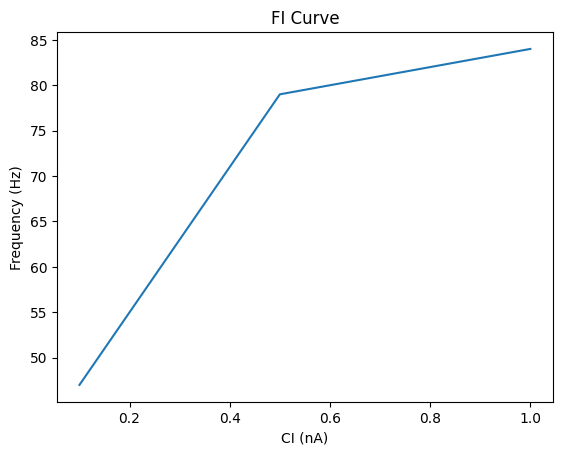

In [67]:
simulated_data = np.load("output/spiker_orig_after/combined_out.npy")

f = []
for trace_id in range(len(simulated_data)):
    f.append(len(dp.find_events(simulated_data[trace_id, ::10, 0].flatten())))

plt.plot([0.1, 0.5, 1.0], f)
plt.xlabel("CI (nA)")
plt.ylabel("Frequency (Hz)")
plt.title("FI Curve")

## 3. Segregated pipeline

### 3.1. Segregate channels into functional modules

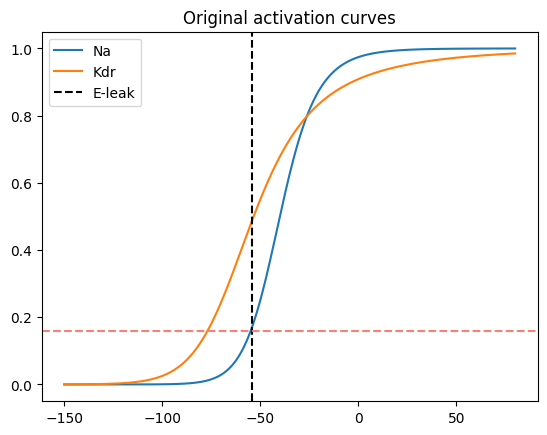

In [69]:
# From ACT/data/Spiker/orig/modfiles/hh.mod
def vtrap(x,y):
    if np.any(np.abs(x/y) < 1e-6):
        vtrap = y * (1 - x/y/2)
    else:
        vtrap = x / (np.exp(x/y) - 1)
    return vtrap

def Na(v):
    aNa = 0.1 * vtrap(-(v + 40), 10)
    bNa =  4 * np.exp(-(v + 65) / 18)
    return aNa / (aNa + bNa)

def Kdr(v):
    aK = 0.01 * vtrap(-(v + 55),10)
    bK = 0.125 * np.exp(-(v + 65) / 80)
    return aK / (aK + bK)

v = np.linspace(-150, 80, 1000)

plt.plot(v, Na(v), label = 'Na')
plt.plot(v, Kdr(v), label = 'Kdr')
plt.title("Original activation curves")
plt.axvline(-54.3, color = 'black', ls = '--', label = "E-leak")
plt.axhline(0.16, color = 'salmon', ls = '--')
plt.legend()

In [70]:
segregator = ACTSegregator()
seg_Na, seg_Kdr = segregator.segregate(v = v, activation_curves = [Na(v), Kdr(v)], v_rest = -65, dv_from_rest = 2)

Update the modfiles with the following:
----------
Activation curve 0:

        :Segregation
        if (v < -61) {
        replace_with_var_name = 0.041 * v + 2.602
        }
        if (v < -63) {
        replace_with_var_name = 0
        }
        
----------
Activation curve 1:

        :Segregation
        if (v < -61) {
        replace_with_var_name = 0.189 * v + 11.915
        }
        if (v < -63) {
        replace_with_var_name = 0
        }
        


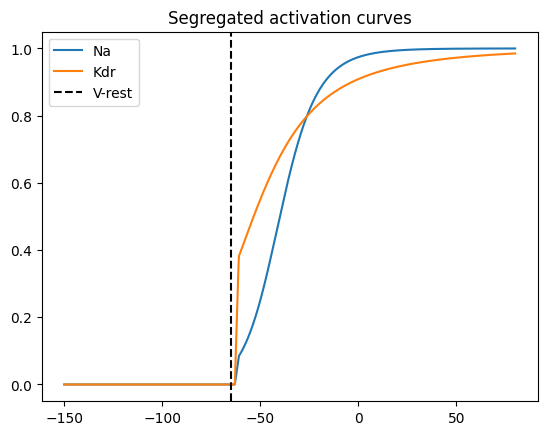

In [71]:
plt.plot(v, seg_Na, label = 'Na')
plt.plot(v, seg_Kdr, label = 'Kdr')
plt.title("Segregated activation curves")
plt.axvline(-65, color = 'black', ls = '--', label = "V-rest")
plt.legend()

### 3.2. Run the passive module

In [2]:
train_cell = ACTCellModel(
    cell_name = "Spiker",
    path_to_hoc_file = "../../data/Spiker/seg/template.hoc",
    path_to_mod_files = "../../data/Spiker/seg/modfiles/",
    passive = ["gl", "el", None],
    active_channels = ["hh_spiker.gnabar", "hh_spiker.gkbar"],
)

In [3]:
simulator = ACTSimulator(output_folder_name = "output")

sim_params = SimulationParameters(
    sim_name = "spiker_dummy",
    sim_idx = 0,
    h_tstop = 10,
    CI = [],
    verbose = True
    )

simulator.run(train_cell, sim_params)


        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        
Soma area: 1110.3645074847766
Soma diam: 18.8
Soma L: 18.8


In [4]:
user_provided_Rin = 246.82388046911376 * 1e6 # (Ohm) 
computed_soma_area = 1110.3645074847766 * 1e-8 # pi * diam * L + pi * diam^2 / 2 ; (cm2)
user_provided_tau = 4.1000000000000005 * 1e-3 # (sec)
user_provided_Vrest = -64.97367898269046 # (mV)

ACTPassiveModule.compute_spp(user_provided_Rin, computed_soma_area, user_provided_tau, user_provided_Vrest)

SettablePassiveProperties(Cm=1.4959983332281186, g_bar_leak=0.0003648776422507606, e_rev_leak=-64.97367898269046, g_bar_h=None)

**NOTE:** adjust these in the hoc file manually.

In [ ]:
# Set simulations
simulator = ACTSimulator(output_folder_name = "output")

sim_params = SimulationParameters(
    sim_name = "seg",
    sim_idx = 0,
    h_celsius = 6.3,
    h_dt = 0.1,
    h_tstop = 1000,
    CI = [ConstantCurrentInjection(amp = -0.2, dur = 700, delay = 100)])

simulator.submit_job(train_cell, sim_params)
simulator.run_jobs(1)

passive_trace = np.load("output/seg/out_0.npy")[:, 0]
seg_gpp = ACTPassiveModule.compute_gpp(passive_trace, 0.1, 100, 700, -0.2)
seg_gpp


        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


GettablePassiveProperties(R_in=246.74113850695056, tau1=4.3, tau2=564.3000000000001, sag_ratio=0.0, V_rest=-65.00000000094045)

In [9]:
pp_error(target_gpp, seg_gpp)

[('R_in', 0.08274196216319751),
 ('tau1', 0.1999999999999993),
 ('tau2', 19.40000000000009),
 ('sag_ratio', 0.0),
 ('V_rest', 0.02632101824998756)]

### 3.3. Optimize active channels

In [ ]:
# Parameter ranges as if provided by the user
gbar_leak = 0.00025
gbar_na = 0.132
gbar_kdr = 0.037

random_state = np.random.RandomState(123)
gbar_na_range = (gbar_na - random_state.uniform(0, gbar_na / 2), gbar_na + random_state.uniform(0, gbar_na / 2))
gbar_kdr_range = (gbar_kdr - random_state.uniform(0, gbar_kdr / 2), gbar_kdr + random_state.uniform(0, gbar_kdr / 2))

print(f"Leak: {gbar_leak_range}")
print(f"Na: {gbar_na_range}")
print(f"Kdr: {gbar_kdr_range}")

Leak: (0.0001629413518002673, 0.00028576741686879743)
Na: (0.1170278040647626, 0.16838677475947084)
Kdr: (0.02368982405896708, 0.04482746951230253)


In [14]:
# Possibly adjsut
train_cell = ACTCellModel(
    cell_name = "Spiker",
    path_to_hoc_file = "../../data/Spiker/seg/template.hoc",
    path_to_mod_files = "../../data/Spiker/seg/modfiles/",
    passive = ["gl", "el", None],
    active_channels = ["hh_spiker.gnabar", "hh_spiker.gkbar"],
)

In [15]:
sim_params = SimulationParameters(
        sim_name = "cell",
        sim_idx = 0,
        h_celsius = 6.3,
        h_dt = 0.1,
        h_tstop = 1000)

optim_params = OptimizationParameters(
    conductance_options = [
        ConductanceOptions(variable_name = "hh_spiker.gnabar", low = gbar_na_range[0], high = gbar_na_range[1], n_slices = 3),
        ConductanceOptions(variable_name = "hh_spiker.gkbar", low = gbar_kdr_range[0], high = gbar_kdr_range[1], n_slices = 3),  
    ],
    CI_options = [
        ConstantCurrentInjection(amp = 0.1, dur = 700, delay = 100),
        ConstantCurrentInjection(amp = 0.5, dur = 700, delay = 100),
        ConstantCurrentInjection(amp = 0.7, dur = 700, delay = 100)
    ],
    filter_parameters = FilterParameters(
        saturation_threshold = -55,
        window_of_inspection = (100, 800)
    )
)

m = ACTModule(
    name = "seg",
    cell = train_cell,
    simulation_parameters = sim_params,
    optimization_parameters = optim_params,
    target_file = "/Users/vladimiromelyusik/ACT/experiments/Spiker/output/target/combined_out.npy"
)

In [16]:
m.run()

Running Module 'seg'...
----------
Simulating train traces...

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        
/Users/vladimiromelyusik/ACT/experiments/Spiker/module_seg/train/combined_out.npy
Training RandomForest...
Predicting on target data...

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/opt/anaconda3/envs/simulations/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


/Users/vladimiromelyusik/ACT/experiments/Spiker/module_seg/eval/combined_out.npy
Evaluating predictions...
Predicting on target data...
{'hh_spiker.gnabar': 0.1368523667529198, 'hh_spiker.gkbar': 0.034586280290161274}
Done.


,metric,value
0,Train MAE (g),0.004034
1,Test SFE (g0),4.479008
2,Test SFE (g1),3.398640
3,Test SFE (g2),6.060767
4,Test MAE (FI),1.100000
5,Runtime (s),11.520000


In [19]:
seg_g = np.array([0.0003648776422507606, 0.1368523667529198,  0.034586280290161274])
mean_absolute_error(target_g, seg_g)

0.0061103213683364336

### 3.4. FI curve after optimization

In [20]:
train_cell = ACTCellModel(
    cell_name = "Spiker",
    path_to_hoc_file = "../../data/Spiker/seg/template.hoc",
    path_to_mod_files = "../../data/Spiker/seg/modfiles/",
    passive = ["gl", "el", None],
    active_channels = ["hh_spiker.gnabar", "hh_spiker.gkbar"],
)

In [21]:
# Set simulations
simulator = ACTSimulator(output_folder_name = "output")


for sim_idx, amp_value in enumerate([0.1, 0.5, 1.0]):
    sim_params = SimulationParameters(
        sim_name = "spiker_seg_after",
        sim_idx = sim_idx,
        h_celsius = 6.3,
        h_dt = 0.1,
        h_tstop = 1000,
        CI = [ConstantCurrentInjection(amp = amp_value, dur = 700, delay = 100)])
    
    train_cell.set_g_bar(
        ["hh_spiker.gnabar", "hh_spiker.gkbar"], 
        seg_g[1:])


    simulator.submit_job(train_cell, sim_params)

simulator.run_jobs(3)

# Combine simulated traces into one dataset for convenience
dp.combine_data("output/spiker_seg_after")


        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        
output/spiker_seg_after/combined_out.npy


Text(0.5, 1.0, 'FI Curve')

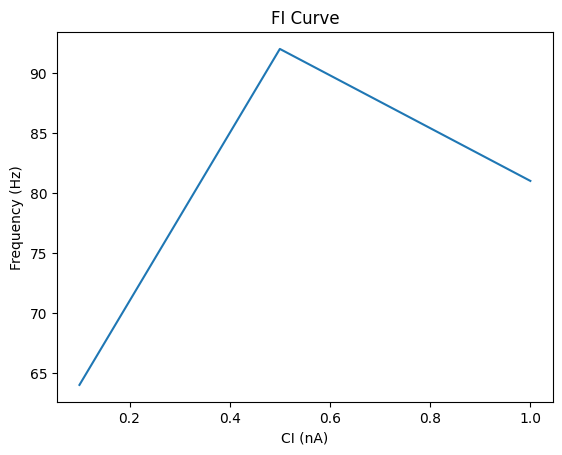

In [23]:
simulated_data = np.load("output/spiker_seg_after/combined_out.npy")

f = []
for trace_id in range(len(simulated_data)):
    f.append(len(dp.find_events(simulated_data[trace_id, ::10, 0].flatten())))

plt.plot([0.1, 0.5, 1.0], f)
plt.xlabel("CI (nA)")
plt.ylabel("Frequency (Hz)")
plt.title("FI Curve")